<table><tr><td>This work sponsored by <a href="https://www.nsf.gov/awardsearch/showAward?AWD_ID=1550551">NSF grant 1550551</a></td><td><img src="https://www.nsf.gov/awardsearch/images/common/nsf_logo_bottom.png"></td></tr></table>


# Numerical Methods

For Numerical Relativity, we need to

* evolve the spacetime (hyperbolic PDEs with "smooth" fields);
* evolve the matter (hyperbolic PDEs with discontinuous fields);
* solve initial data (elliptic PDEs);
* extract gravitational waves (interpolation and integration);
* find and analyse horizons (interpolation, BVPs).

These can be built on some simple foundations. 

The general concepts that underpin most numerical methods are

1. the solution of linear systems $A {\bf x} = {\bf b}$;
2. the solution of nonlinear root-finding problems ${\bf f} ( {\bf x} ) = {\bf 0}$;
3. the representation of a function or field $f(x)$ by discrete data $f_i$ at points $x_i$, by interpolation or other means;
4. the (discrete) Fast Fourier Transform;
5. stochastic concepts and methods.

For Numerical Relativity, there has been little need (yet!) for stochastic methods, and the use of FFTs is mostly restricted to analysis. All of these points can be found in standard numerical packages and libraries: the question, however, is

1. what do we need to understand about these methods before implementing or using them?
2. when is it faster or better to implement our own version rather than using a library?

# Finite differencing

As a first step we'll quickly cover *finite differencing*: the approximation of derivatives of a function $f$ when the only information about $f$ is its value at a set of points, or nodes, $\{x_i\}$, denoted $\{f_i\}$.

Here we have the "representation of a function" problem. We represent the function $f$ using a *piecewise polynomial* function $g$. This polynomial must interpolate $f$: that is, $g(x_i) \equiv f(x_i) = f_i$. We then approximate derivatives of $f$ by derivatives of $g$.

As simple examples, let's assume we know three points, $\{f_{i-1}, f_i, f_{i+1}\}$. Then we have the linear polynomial approximations

$$
  g_{FD} = \frac{x - x_{i+1}}{x_i - x_{i+1}} f_i + \frac{x - x_{i}}{x_{i+1} - x_{i}} f_{i+1}
$$

and

$$
  g_{BD} = \frac{x - x_{i}}{x_{i-1} - x_{i}} f_{i-1} + \frac{x - x_{i-1}}{x_i - x_{i-1}} f_i
$$

or the quadratic polynomial approximation

$$
  g_{CD} = \frac{(x - x_{i})(x - x_{i+1})}{(x_{i-1} - x_{i})(x_{i-1} - x_{i+1})} f_{i-1} + \frac{(x - x_{i-1})(x - x_{i+1})}{(x_{i} - x_{i-1})(x_{i} - x_{i+1})} f_{i} + \frac{(x - x_{i-1})(x - x_{i})}{(x_{i+1} - x_{i-1})(x_{i+1} - x_{i})} f_{i+1}.
$$

Note how this Lagrange form is built out of *indicator polynomials* that take the value $1$ at one node and vanish at all others.

By differentiating these polynomial interpolating functions we get approximations to the derivatives of $f$. Each approximation is different, with different errors. 

We'll assume that the nodes are equally spaced, with grid spacing $\Delta x = x_{i+1} - x_i$. The approximations above give the standard *forward difference*

$$
  \left. \frac{\partial g_{FD}}{\partial x} \right|_{x = x_i} \to \left. \frac{\partial f}{\partial x} \right|_{x = x_i} = \frac{1}{\Delta x} \left( f_{i+1} - f_i \right) + {\cal O} \left( \Delta x \right),
$$

the standard *backward difference*

$$
  \left. \frac{\partial g_{BD}}{\partial x} \right|_{x = x_i} \to \left. \frac{\partial f}{\partial x} \right|_{x = x_i} = \frac{1}{\Delta x} \left( f_{i} - f_{i-1} \right) + {\cal O} \left( \Delta x \right),
$$

and the standard *central difference* approximations

\begin{align}
  \left. \frac{\partial g_{CD}}{\partial x} \right|_{x = x_i} & \to \left. \frac{\partial f}{\partial x} \right|_{x = x_i} \\ & = \frac{1}{2 \, \Delta x} \left( f_{i+1} - f_{i-1} \right) + {\cal O} \left( \Delta x^2 \right), \\
  \left. \frac{\partial^2 g_{CD}}{\partial x^2} \right|_{x = x_i} & \to \left. \frac{\partial^2 f}{\partial x^2} \right|_{x = x_i} \\ & = \frac{1}{\left( \Delta x \right)^2} \left( f_{i-1} - 2 f_i + f_{i+1} \right) + {\cal O} \left( \Delta x^2 \right).
\end{align}

The error is most conveniently derived by expressing $f_{i-1}$ and $f_{i+1}$ using the Taylor expansion of $f(x)$ around $x_i$, i.e.

$$
f_{i-1} = f_i - \left. \frac{\partial f}{\partial x} \right|_{x = x_i}\!\! \Delta x + \frac{1}{2} \left . \frac{\partial^2 f}{\partial x^2} \right|_{x = x_i}\!\! \Delta x^2 - \frac{1}{6} \left . \frac{\partial^3 f}{\partial x^3} \right|_{x = x_i}\!\! \Delta x^3 + {\cal O} \left ( \Delta x^4 \right)
$$
and
$$
f_{i+1} = f_i + \left. \frac{\partial f}{\partial x} \right|_{x = x_i}\!\! \Delta x + \frac{1}{2} \left . \frac{\partial^2 f}{\partial x^2} \right|_{x = x_i}\!\! \Delta x^2 + \frac{1}{6} \left . \frac{\partial^3 f}{\partial x^3} \right|_{x = x_i}\!\! \Delta x^3 + {\cal O} \left ( \Delta x^4 \right)
$$

## Testing this in code

We'll use finite differencing repeatedly. To test our code we'll be testing the differencing. Let's check the above approximations applied to a simple function,

$$
  f(x) = \exp \left[ x \right].
$$

All derivatives are the same as the original function, which evaluated at $x=0$ gives $1$.

First we write the functions, then we test them.

In [2]:
def backward_differencing(f, x_i, dx):
    """
    Backward differencing of f at x_i with grid spacing dx.
    """
    f_i = f(x_i)
    f_i_minus_1 = f(x_i - dx)
    return (f_i - f_i_minus_1)/dx

In [3]:
def forward_differencing(f, x_i, dx):
    """
    Forward differencing of f at x_i with grid spacing dx.
    """
    f_i = f(x_i)
    f_i_plus_1 = f(x_i + dx)
    return (f_i_plus_1 - f_i)/dx

In [4]:
def central_differencing(f, x_i, dx):
    """
    Second order central differencing of f at x_i with grid spacing dx.
    """
    f_i = f(x_i)
    f_i_minus_1 = f(x_i - dx)
    f_i_plus_1 = f(x_i + dx)
    
    first_derivative = (f_i_plus_1 - f_i_minus_1) / (2.0*dx)
    second_derivative = (f_i_plus_1 - 2.0*f_i + f_i_minus_1) / (dx**2)
    
    return first_derivative, second_derivative

In [6]:
import numpy as np

In [12]:
bd = backward_differencing(np.exp, 0.0, dx=1.0)
fd = forward_differencing(np.exp, 0.0, dx=1.0)
cd1, cd2 = central_differencing(np.exp, 0.0, dx=1.0)

print("Backward difference should be 1, is {}, error {}".format(bd, abs(bd - 1.0)))
print("Forward difference should be 1, is {}, error {}".format(fd, abs(fd - 1.0)))
print("Central difference (1st derivative) should be 1, is {}, error {}".format(cd1, abs(cd1 - 1.0)))
print("Central difference (2nd derivative) should be 1, is {}, error {}".format(cd2, abs(cd2 - 1.0)))

Backward difference should be 1, is 0.6321205588285577, error 0.36787944117144233
Forward difference should be 1, is 1.718281828459045, error 0.7182818284590451
Central difference (1st derivative) should be 1, is 1.1752011936438014, error 0.17520119364380138
Central difference (2nd derivative) should be 1, is 1.0861612696304874, error 0.08616126963048742


The errors here are significant. What matters is how fast the errors reduce as we change the grid spacing. Try changing from $\Delta x = 1$ to $\Delta x = 0.1$:

In [13]:
bd = backward_differencing(np.exp, 0.0, dx=0.1)
fd = forward_differencing(np.exp, 0.0, dx=0.1)
cd1, cd2 = central_differencing(np.exp, 0.0, dx=0.1)

print("Backward difference should be 1, is {}, error {}".format(bd, abs(bd - 1.0)))
print("Forward difference should be 1, is {}, error {}".format(fd, abs(fd - 1.0)))
print("Central difference (1st derivative) should be 1, is {}, error {}".format(cd1, abs(cd1 - 1.0)))
print("Central difference (2nd derivative) should be 1, is {}, error {}".format(cd2, abs(cd2 - 1.0)))

Backward difference should be 1, is 0.9516258196404048, error 0.048374180359595176
Forward difference should be 1, is 1.0517091807564771, error 0.051709180756477124
Central difference (1st derivative) should be 1, is 1.001667500198441, error 0.0016675001984409743
Central difference (2nd derivative) should be 1, is 1.0008336111607228, error 0.0008336111607227803


We see *roughly* the expected scaling, with forward and backward differencing errors reducing by roughly $10$, and central differencing errors reducing by roughly $10^2$.

## Convergence

The feature that we always want to show is that the error $\cal E$ decreases with the grid spacing $\Delta x$. In particular, for most methods in Numerical Relativity, we expect a power law relationship:

$$
  {\cal E} \propto \left( \Delta x \right)^p.
$$

If we can measure the error (by knowing the exact solution) then we can measure the *convergence rate* $p$, by using

$$
  \log \left( {\cal E} \right) = p \, \log \left( \Delta x \right) + \text{constant}.
$$

That is $p$ is the slope of the best-fit straight line through the plot of the error against the grid spacing, on a logarithmic scale.

If we do not know the exact solution (the usual case), we can use *self convergence* to do the same measurement.

We check this for our finite differencing above.

In [14]:
dxs = np.logspace(-5, 0, 10)
bd_errors = np.zeros_like(dxs)
fd_errors = np.zeros_like(dxs)
cd1_errors = np.zeros_like(dxs)
cd2_errors = np.zeros_like(dxs)

for i, dx in enumerate(dxs):
    bd = backward_differencing(np.exp, 0.0, dx)
    fd = forward_differencing(np.exp, 0.0, dx)
    cd1, cd2 = central_differencing(np.exp, 0.0, dx)
    
    bd_errors[i] = abs(bd - 1.0)
    fd_errors[i] = abs(fd - 1.0)
    cd1_errors[i] = abs(cd1 - 1.0)
    cd2_errors[i] = abs(cd2 - 1.0)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


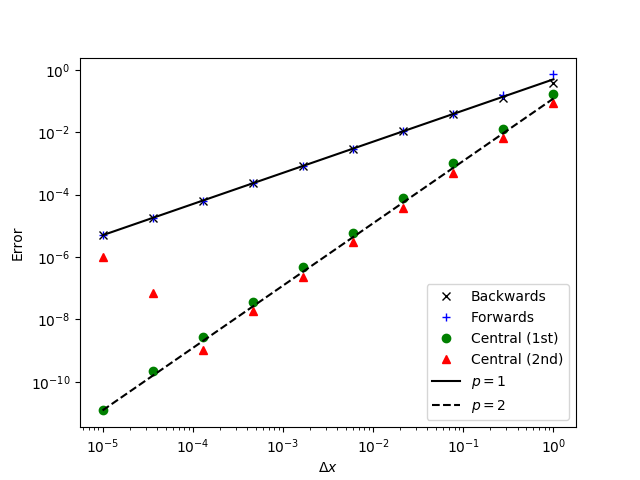

In [15]:
plt.figure()
plt.loglog(dxs, bd_errors, 'kx', label='Backwards')
plt.loglog(dxs, fd_errors, 'b+', label='Forwards')
plt.loglog(dxs, cd1_errors, 'go', label='Central (1st)')
plt.loglog(dxs, cd2_errors, 'r^', label='Central (2nd)')
plt.loglog(dxs, dxs*(bd_errors[0]/dxs[0]), 'k-', label=r"$p=1$")
plt.loglog(dxs, dxs**2*(cd1_errors[0]/dxs[0]**2), 'k--', label=r"$p=2$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

Forwards and backwards differencing are converging at first order ($p=1$). Central differencing is converging at second order ($p=2$) until floating point roundoff effects start causing problems at small $\Delta x$.

# Extension exercises

##### Self convergence

By definition, the error ${\cal E}(\Delta x)$ is a function of the grid spacing, as is our numerical approximation of the thing we're trying to compute $F(\Delta x)$ (above $F$ was the derivative of $f$, evaluated at $0$). This gives

$$
  {\cal E}(\Delta x) = F \left( \Delta x \right) - F \left( 0 \right)
$$

or

$$
  F \left( \Delta x \right) = F \left( 0 \right) + {\cal E}(\Delta x).
$$

Of course, $F(0)$ is the exact solution we're trying to compute. However, by subtracting any *two* approximations we can eliminate the exact solution. Using the power law dependence

$$
  {\cal E}(\Delta x) = C \left( \Delta x \right)^p
$$

this gives

$$
  F \left( \alpha \Delta x \right) - F \left( \Delta x \right) = C \left( \Delta x \right)^p \left( \alpha^p - 1 \right).
$$

We still do not know the value of the constant $C$. However, we can use *three* approximations to eliminate it (note for convenience we chose the same ratio $\alpha$ between the first two resolutions as
between the last two):

$$
  \frac{F \left( \alpha^2 \Delta x \right) - F \left( \alpha \Delta x \right)}{F \left( \alpha \Delta x \right) - F \left( \Delta x \right)} = \frac{\left( \alpha^{2p} - \alpha^p \right)}{\left( \alpha^p - 1 \right)} = \alpha^p.
$$

So the *self-convergence rate* is

$$
  p = \log_{\alpha} \left| \frac{F \left( \alpha^2 \Delta x \right) - F \left( \alpha \Delta x \right)}{F \left( \alpha \Delta x \right) - F \left( \Delta x \right)} \right|.
$$

Compute this self-convergence rate for all the cases above.

In [39]:
dxs = np.logspace(-5, 0, 10)
F_bd = np.zeros_like(dxs)
F_fd = np.zeros_like(dxs)
F_cd1 = np.zeros_like(dxs)
F_cd2 = np.zeros_like(dxs)

for i, dx in enumerate(dxs):
    F_bd[i] = backward_differencing(np.exp, 0.0, dx)
    F_fd[i] = forward_differencing(np.exp, 0.0, dx)
    F_cd1[i], F_cd2[i] = central_differencing(np.exp, 0.0, dx)
    
alpha = 2
bd_cfactor = np.log(abs((F_bd[2:] - F_bd[1:-1])/(F_bd[1:-1] - F_bd[0:-2])))/np.log(alpha)
fd_cfactor = np.log(abs((F_fd[2:] - F_fd[1:-1])/(F_fd[1:-1] - F_fd[0:-2])))/np.log(alpha)
cd1_cfactor = np.log(abs((F_cd1[2:] - F_cd1[1:-1])/(F_cd1[1:-1] - F_cd1[0:-2])))/np.log(alpha)
cd2_cfactor = np.log(abs((F_cd2[2:] - F_cd2[1:-1])/(F_cd2[1:-1] - F_cd2[0:-2])))/np.log(alpha)

<IPython.core.display.Javascript object>


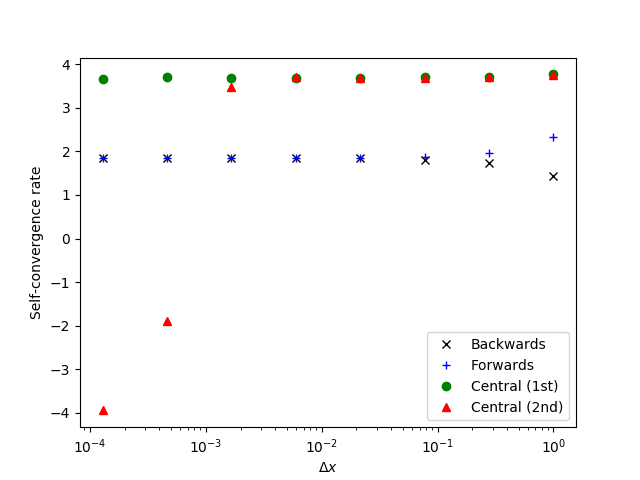

In [44]:
plt.figure()
plt.semilogx(dxs[2:], bd_cfactor, 'kx', label='Backwards')
plt.semilogx(dxs[2:], fd_cfactor, 'b+', label='Forwards')
plt.semilogx(dxs[2:], cd1_cfactor, 'go', label='Central (1st)')
plt.semilogx(dxs[2:], cd2_cfactor, 'r^', label='Central (2nd)')
plt.xlabel(r"$\Delta x $")
plt.ylabel("Self-convergence rate")
plt.legend(loc="lower right")
plt.show()

##### Higher order

Show, either by Taylor expansion, or by constructing the interpolating polynomial, that the fourth order central differencing approximations are

\begin{align}
  \left. \frac{\partial f}{\partial x} \right|_{x = x_i} & = \frac{1}{12 \, \Delta x} \left( -f_{i+2} + 8 f_{i+1} - 8 f_{i-1} + f_{i-2} \right) + {\cal O} \left( \Delta x^4 \right), \\
  \left. \frac{\partial^2 f}{\partial x^2} \right|_{x = x_i} & = \frac{1}{12 \left( \Delta x \right)^2} \left( -f_{i-2} + 16 f_{i-1} - 30 f_i + 16 f_{i+1} - f_{i+2} \right) + {\cal O} \left( \Delta x^4 \right).
\end{align}

##### Measure the convergence rate

Using `numpy.polyfit`, directly measure the convergence rate for the algorithms above. Be careful to exclude points where finite differencing effects cause problems. Repeat the test for the fourth order formulas above.

##### This material is a slight modification of Ian Hawke's material for the 2016 Einstein Toolkit school in Trento, Italy.